In [11]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt

In [12]:
DATA_DIR = "/content/drive/MyDrive/chest_xray"
IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

train_raw = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train", label_mode="binary",
    image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=True, seed=SEED, validation_split=0.1, subset="training"
)
val_raw = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train", label_mode="binary",
    image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=True, seed=SEED, validation_split=0.1, subset="validation"
)
test_ds = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/test", label_mode="binary",
    image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_raw.prefetch(AUTOTUNE)
val_ds   = val_raw.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

class_names = train_raw.class_names
print("Classes:", class_names)

Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


In [13]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="aug")


In [14]:
def build_strong_cnn(input_shape=(224,224,3)):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)

    # Block 1
    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Block 4
    x = layers.Conv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Block 5 (deepest)
    x = layers.Conv2D(512, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Dense head
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="Strong_Custom_CNN")

model = build_strong_cnn()
model.summary()

Model: "Strong_Custom_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug (Sequential)                │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 1,704,129 (6.50 MB)

 Trainable params: 1,702,145 (6.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # small lr for stability
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)

In [16]:
class_weights = {0: 1.5, 1: 1.0}  # NORMAL weighted more

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auc", mode="max", patience=5, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6
    )
]

history = model.fit(
    train_ds, validation_data=val_ds,
    epochs=25,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy: 0.8348 - auc: 0.8886 - loss: 0.4443 - precision: 0.9066 - recall: 0.8634 - val_accuracy: 0.7601 - val_auc: 0.9364 - val_loss: 0.5968 - val_precision: 0.7596 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.9178 - auc: 0.9670 - loss: 0.2488 - precision: 0.9613 - recall: 0.9251 - val_accuracy: 0.8484 - val_auc: 0.9760 - val_loss: 0.3444 - val_precision: 0.8347 - val_recall: 0.9975 - learning_rate: 1.0000e-04
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.9289 - auc: 0.9713 - loss: 0.2334 - precision: 0.9614 - recall: 0.9407 - val_accuracy: 0.4165 - val_auc: 0.7865 - val_loss: 2.7868 - val_precision: 0.9892 - val_recall: 0.2329 - learning_rate: 1.0000e-04
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.9398 - auc: 0.9808 - loss: 0.1902 - precision: 0.9680 - recall: 0.9489 - val_accuracy: 0.8906 - val_auc: 0.9619 

In [17]:
results = model.evaluate(test_ds, return_dict=True)
print("Test Results:", results)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8164 - auc: 0.6292 - loss: 0.5474 - precision: 0.4703 - recall: 0.6438
Test Results: {'accuracy': 0.8685897588729858, 'auc': 0.9392120242118835, 'loss': 0.3697236478328705, 'precision': 0.8515982031822205, 'recall': 0.9564102292060852}


In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score

y_true = np.concatenate([y for _, y in test_ds]).astype(int).ravel()
y_prob = model.predict(test_ds, verbose=0).ravel()

precisions, recalls, thr = precision_recall_curve(y_true, y_prob)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)

best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5

y_pred = (y_prob >= best_thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

spec = tn / (tn+fp+1e-9)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred)

print(f"Best threshold: {best_thr:.3f}")
print(f"Precision {prec:.3f} | Recall {rec:.3f} | Specificity {spec:.3f} | F1 {f1:.3f}")


Best threshold: 0.679
Precision 0.889 | Recall 0.928 | Specificity 0.808 | F1 0.908


In [19]:

model = keras.models.load_model("lung_cnn_custom_strong.h5")
model.layers[1].summary()  # Verify data_augmentation block position


Model: "augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow import keras
from tensorflow.keras import layers, Model

# Load original model (the one that works fine in Colab)
model = keras.models.load_model("lung_cnn_custom_strong.h5")

# Find the first Conv2D layer (we start from there)
conv_start = None
for i, layer in enumerate(model.layers):
    if isinstance(layer, layers.Conv2D):
        conv_start = i
        break

print(f"Starting from layer {model.layers[conv_start].name} (index {conv_start})")

# Build new model starting from that layer
new_input = keras.Input(shape=(224, 224, 3))
x = new_input

for layer in model.layers[conv_start:]:
    x = layer(x)

inference_model = Model(inputs=new_input, outputs=x, name="Strong_CNN_Inference")

# Confirm structure
inference_model.summary()

# Save clean model
inference_model.save("lung_cnn_inference.keras")
print("✅ Saved 'lung_cnn_inference.keras' (no augmentation, safe for backend)")

Starting from layer conv2d (index 2)


Model: "Strong_CNN_Inference"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 1,704,129 (6.50 MB)

 Trainable params: 1,702,145 (6.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

✅ Saved 'lung_cnn_inference.keras' (no augmentation, safe for backend)


In [21]:
import json

model.save("lung_cnn_custom_strong.h5")
with open("lung_cnn_threshold.json","w") as f:
    json.dump({"threshold": float(best_thr)}, f)



TypeError: cannot pickle 'module' object

In [22]:
import json, cv2, numpy as np, matplotlib.pyplot as plt
from tensorflow import keras

# load your trained model and tuned threshold
clf = keras.models.load_model("lung_cnn_custom_strong.h5", compile=False)
with open("lung_cnn_threshold.json") as f:
    tuned_thr = float(json.load(f)["threshold"])

def predict_custom_image(path, thr=tuned_thr, img_size=(224,224)):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vis = cv2.resize(img, img_size)
    x = vis.astype("float32")[None, ...]
    x = keras.applications.efficientnet.preprocess_input(x)
    p = clf.predict(x, verbose=0)[0,0]
    label = "PNEUMONIA" if p >= thr else "NORMAL"
    return p, label, vis, thr

ValueError: No model config found in the file at lung_cnn_custom_strong.h5.

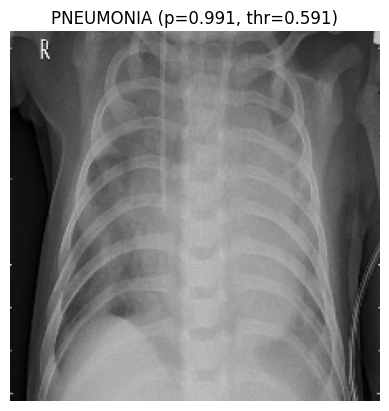

In [23]:
prob, label, vis, thr = predict_custom_image("/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_480.jpeg")

plt.imshow(vis)
plt.title(f"{label} (p={prob:.3f}, thr={thr:.3f})")
plt.axis("off")
plt.show()